In [1]:
pip install cmake

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pennylane==0.41.1 pennylane-lightning torch matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pennylane as qml
print(qml.__version__)

0.41.1


In [4]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from data_loader import get_mnist_dataset

# Jupyter settings
%matplotlib inline
plt.style.use("seaborn-v0_8")

print(f"[INFO] Torch version      : {torch.__version__}")
print(f"[INFO] Matplotlib version : {plt.matplotlib.__version__}")
print(f"[INFO] NumPy version       : {np.__version__}")


[INFO] Torch version      : 2.5.1+cu118
[INFO] Matplotlib version : 3.10.3
[INFO] NumPy version       : 2.1.2


In [5]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

# Dynamically add the project root (1 level up from /notebooks) 
PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))  

# Import dataset utility
from src.data_loader import get_mnist_dataset

DATASET_PATH = PROJECT_ROOT / "datasets"

images, labels = get_mnist_dataset(
    data_dir=DATASET_PATH,             
    binary_digits=tuple(range(10)),    # Digits 0 to 9
    image_size=(8, 8),                 # Resize for quantum encoding
    train=True,                        # Training split
    download=True,                     # Download if missing
    limit_samples=None                 # Use full dataset 
)

#Log Dataset Info
print(f"[INFO] Loaded {images.shape[0]} training samples")
print(f"[INFO] Image tensor shape: {images.shape} (N, C, H, W)")
print(f"[INFO] Label tensor shape: {labels.shape}")
print(f"[INFO] Unique labels: {sorted(torch.unique(labels).tolist())}")


[INFO] Loaded 60000 training samples
[INFO] Image tensor shape: torch.Size([60000, 1, 28, 28]) (N, C, H, W)
[INFO] Label tensor shape: torch.Size([60000])
[INFO] Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


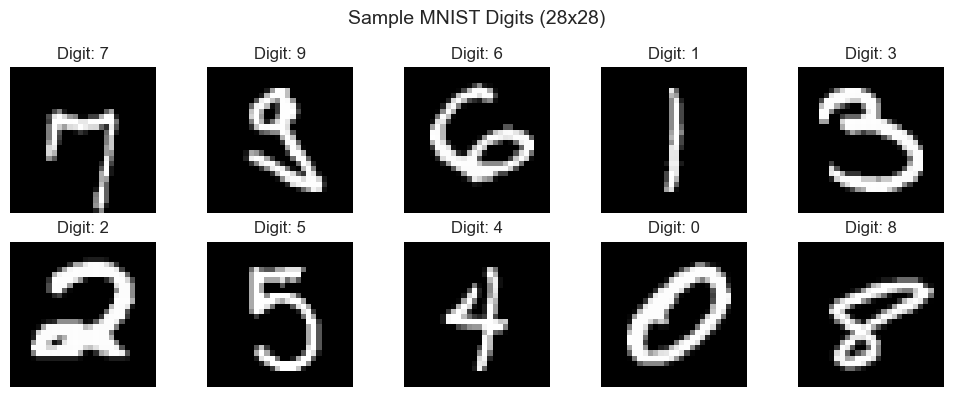

In [6]:
def plot_sample_grid(images, labels, num_classes=10):
    """
    Plot one image per digit (0 to 9) in a 2x5 grid.
    Assumes images are in (N, 1, 28, 28) format for MNIST.

    Args:
        images (torch.Tensor): Images of shape [N, 1, 28, 28].
        labels (torch.Tensor): Labels of shape [N].
        num_classes (int): Number of classes to display (default: 10).
    """
    if images.shape[1:] != (1, 28, 28):
        raise ValueError(f"Expected images of shape [N, 1, 28, 28], got {images.shape}")

    plt.figure(figsize=(10, 4))
    shown = set()
    count = 0

    for idx, (img, label) in enumerate(zip(images, labels)):
        digit = int(label.item())
        if digit in shown:
            continue
        shown.add(digit)

        ax = plt.subplot(2, 5, count + 1)
        ax.imshow(img.squeeze(0), cmap='gray', interpolation='nearest')
        ax.set_title(f"Digit: {digit}", fontsize=12)
        ax.axis("off")
        count += 1

        if count == min(num_classes, 10):  # Ensure we don't exceed grid size
            break

    if count < num_classes:
        print(f"Warning: Only {count} unique digits found, expected {num_classes}")

    plt.suptitle("Sample MNIST Digits (28x28)", fontsize=14)
    plt.tight_layout()
    plt.show()

# === Call Visualization ===
# Assuming images and labels are loaded from data_loader.py
# Example: images, labels = get_mnist_dataset(image_size=(28, 28), limit_samples=1000)
plot_sample_grid(images, labels)

2025-07-12 14:51:23,273 [INFO] Initialized 'lightning.qubit' device with 16 qubits.
D:\QNN_Robustness_Project\env\lib\site-packages\pennylane\workflow\qnode.py:138: UserWarning: Received gradient_kwarg dtype, which is not included in the list of standard qnode gradient kwargs. Please specify all gradient kwargs through the gradient_kwargs argument as a dictionary.
  warnings.warn(


[INFO] Visualizing digit: 4
[INFO] Original image shape: torch.Size([1, 1, 28, 28]), min: 0.000, max: 1.000
[INFO] Preprocessed features shape: torch.Size([1, 16])


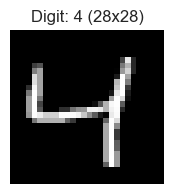

2025-07-12 14:51:23,685 [INFO] Computed expectation values for batch of shape torch.Size([1, 16])


[INFO] Drawing quantum encoding circuit...
 0: ──RY(0.07)──┤  
 1: ──RY(-0.35)─┤  
 2: ──RY(-0.23)─┤  
 3: ──RY(-0.39)─┤  
 4: ──RY(0.80)──┤  
 5: ──RY(-0.12)─┤  
 6: ──RY(0.39)──┤  
 7: ──RY(0.29)──┤  
 8: ──RY(0.14)──┤  
 9: ──RY(0.12)──┤  
10: ──RY(0.32)──┤  
11: ──RY(-0.50)─┤  
12: ──RY(-0.02)─┤  
13: ──RY(0.28)──┤  
14: ──RY(-0.05)─┤  
15: ──RY(-0.38)─┤  
[INFO] Encoding image to quantum state...
[INFO] Successfully encoded state. Shape: torch.Size([1, 16])


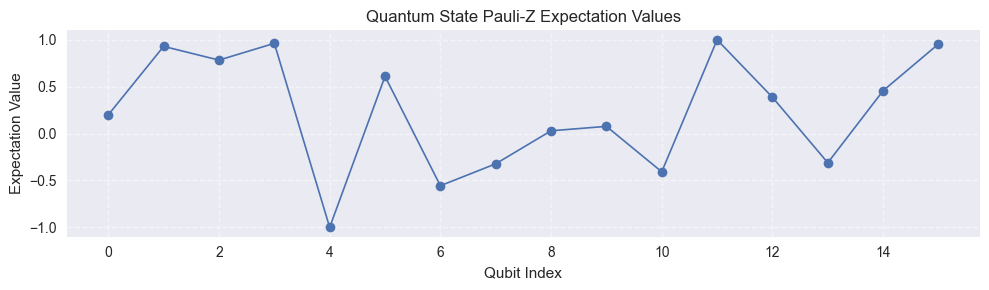

In [7]:
# === Setup Environment ===
import os
import sys
from pathlib import Path
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# === Imports ===
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src.data_loader import get_mnist_dataset
from src.encoder import visualize_circuit, get_encoded_state

# === Load Real MNIST Dataset ===
images, labels = get_mnist_dataset(
    data_dir=str(PROJECT_ROOT / "datasets"),
    image_size=(28, 28),  # Keep 28x28 images
    binary_digits=tuple(range(10)),
    train=True,
    download=True,
    limit_samples=10  # Small sample for visualization
)

# === Preprocessing Layer ===
class Preprocess(nn.Module):
    def __init__(self, out_features=16):  # Match NUM_QUBITS=16 in encoder.py
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [batch, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [batch, 16, 14, 14]
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [batch, 32, 7, 7]
            nn.Flatten(),  # [batch, 32*7*7 = 1568]
            nn.Linear(1568, out_features)  # [batch, 16]
        )

    def forward(self, x):
        return self.model(x)

# === Select and Preprocess Sample Image ===
idx = 0
original_img = images[idx:idx+1]  # [1, 1, 28, 28]
sample_lbl = labels[idx].item()

# Apply preprocessing
preprocess = Preprocess(out_features=16).double()  # Match encoder.py dtype
sample_features = preprocess(original_img)  # [1, 16]

print(f"[INFO] Visualizing digit: {sample_lbl}")
print(f"[INFO] Original image shape: {original_img.shape}, min: {original_img.min():.3f}, max: {original_img.max():.3f}")
print(f"[INFO] Preprocessed features shape: {sample_features.shape}")

# === Plot the Input Image ===
plt.figure(figsize=(2, 2))
plt.imshow(original_img.squeeze(0).squeeze(0), cmap="gray")
plt.title(f"Digit: {sample_lbl} (28x28)")
plt.axis("off")
plt.show()

# === Visualize Quantum Circuit ===
print("[INFO] Drawing quantum encoding circuit...")
visualize_circuit(sample_features[0])  # Pass single sample [16]

# === Encode Image to Quantum State (Pauli-Z Expectation Values) ===
print("[INFO] Encoding image to quantum state...")
encoded_state = get_encoded_state(sample_features)  # [1, 16]
print(f"[INFO] Successfully encoded state. Shape: {encoded_state.shape}")

# === Plot Expectation Value Distribution ===
plt.figure(figsize=(10, 3))
plt.plot(encoded_state[0].detach().numpy(), linewidth=1.2, marker='o')  # Use first sample
plt.title("Quantum State Pauli-Z Expectation Values")
plt.xlabel("Qubit Index")
plt.ylabel("Expectation Value")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()